RF - Nonorthogonal (D) + sample splitting: 0.0392
RF - Nonorthogonal (Y) + sample splitting: 0.3356
RF - Orthogonal + sample splitting: 0.0958


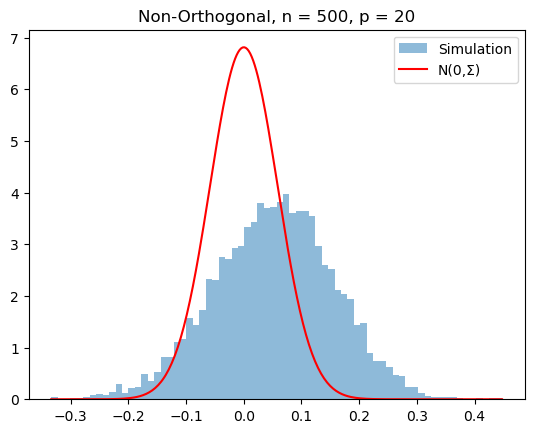

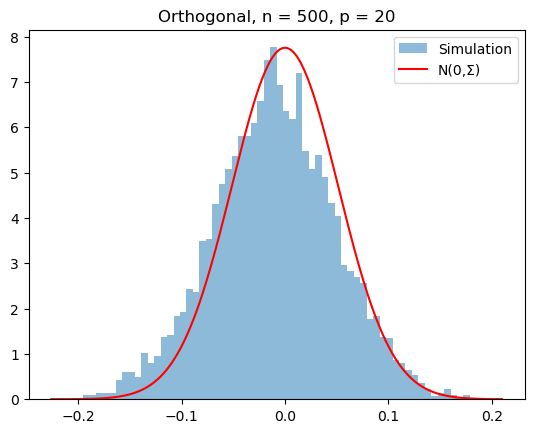

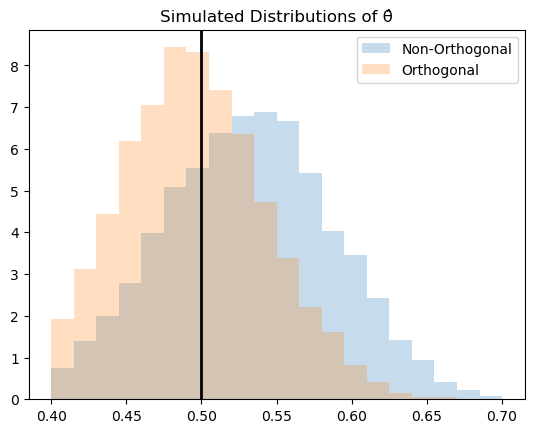

In [1]:
import numpy as np
from scipy.linalg import toeplitz, cholesky
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt

# Simulation parameters
np.random.seed(2162016)
nrep   = 5000
n      = 500
p      = 20
alpha  = 0.5

# Covariance for X ~ N(0, Σ) with Σ_{ij} = 0.7^{|i-j|}
Sigma = toeplitz(0.7**np.arange(p))
S = cholesky(Sigma, lower=True)

def single_run(seed):
    rng = np.random.RandomState(seed)
    # 1) Draw covariates
    X = rng.randn(n, p).dot(S.T)
    
    # 2) Generate D and Y
    d = X[:,0] + 0.25 * np.exp(X[:,2])/(1 + np.exp(X[:,2])) + rng.randn(n)
    y = alpha * d + np.exp(X[:,0])/(1 + np.exp(X[:,0])) + 0.25 * X[:,2] + rng.randn(n)
    
    # 3) Two-fold sample splitting
    idx = rng.permutation(n)
    half = n // 2
    train1, test1 = idx[:half], idx[half:]
    train2, test2 = test1, train1
    
    # Helper to fit RF and get residuals
    def rf_residuals(train_idx, test_idx):
        rf_y = RandomForestRegressor(n_estimators=500, n_jobs=1)
        rf_y.fit(X[train_idx], y[train_idx])
        yhat = rf_y.predict(X[test_idx])
        ry = y[test_idx] - yhat
        
        rf_d = RandomForestRegressor(n_estimators=500, n_jobs=1)
        rf_d.fit(X[train_idx], d[train_idx])
        dhat = rf_d.predict(X[test_idx])
        rd = d[test_idx] - dhat
        
        return ry, rd, yhat, dhat
    
    # First split
    ry1, rd1, yhat1, dhat1 = rf_residuals(train1, test1)
    # Second split
    ry2, rd2, yhat2, dhat2 = rf_residuals(train2, test2)
    
    # Compute non-orthogonal (D) + sample splitting
    def compute_sss(rd, d_true, y_true):
        beta = np.sum(rd * y_true) / np.sum(rd * d_true)
        se = np.sqrt(np.mean((y_true - d_true * beta)**2) * np.sum(rd**2) / (np.sum(rd * d_true)**2))
        return beta, se
    
    beta_sss1, se_sss1 = compute_sss(rd1, d[test1], y[test1])
    beta_sss2, se_sss2 = compute_sss(rd2, d[test2], y[test2])
    beta_sss  = 0.5 * (beta_sss1 + beta_sss2)
    se_sss    = np.sqrt(0.25 * se_sss1**2 + 0.25 * se_sss2**2)
    
    # Compute non-orthogonal (Y) + sample splitting
    def compute_gsss(yhat, dhat, rd, d_true, y_true):
        beta = (d_true @ (y_true - (yhat - dhat * beta_sss1))) / (d_true @ d_true)
        # residual for gy: y - (yhat - dhat*beta)
        ghat = yhat - dhat * beta_sss1
        gy = y_true - ghat
        beta = np.sum(d_true * gy) / np.sum(d_true**2)
        se = np.sqrt(np.sum((gy - d_true * beta)**2) / (len(gy) - 1) * (1 / np.sum(d_true**2)))
        return beta, se
    
    beta_gsss1, se_gsss1 = compute_gsss(yhat1, dhat1, rd1, d[test1], y[test1])
    beta_gsss2, se_gsss2 = compute_gsss(yhat2, dhat2, rd2, d[test2], y[test2])
    beta_gsss = 0.5 * (beta_gsss1 + beta_gsss2)
    se_gsss   = np.sqrt(0.25 * se_gsss1**2 + 0.25 * se_gsss2**2)
    
    # Compute orthogonal + sample splitting
    def compute_sds(rd, ry):
        beta = np.sum(rd * ry) / np.sum(rd**2)
        se = np.sqrt(np.sum((ry - rd * beta)**2) / (len(ry) - 1) * (1 / np.sum(rd**2)))
        return beta, se
    
    beta_sds1, se_sds1 = compute_sds(rd1, ry1)
    beta_sds2, se_sds2 = compute_sds(rd2, ry2)
    beta_sds = 0.5 * (beta_sds1 + beta_sds2)
    se_sds   = np.sqrt(0.25 * se_sds1**2 + 0.25 * se_sds2**2)
    
    return beta_sss, se_sss, beta_gsss, se_gsss, beta_sds, se_sds

# Run simulations in parallel
results = Parallel(n_jobs=cpu_count()-1)(
    delayed(single_run)(i) for i in range(nrep)
)
results = np.array(results)

# Extract estimates and standard errors
rfsss  = results[:, 0:2]
rfgsss = results[:, 2:4]
rfsds  = results[:, 4:6]

# Coverage rates
cov_sss  = np.mean(np.abs(rfsss[:,0]  - alpha) / rfsss[:,1]  > 1.96)
cov_gsss = np.mean(np.abs(rfgsss[:,0] - alpha) / rfgsss[:,1] > 1.96)
cov_sds  = np.mean(np.abs(rfsds[:,0]  - alpha) / rfsds[:,1]  > 1.96)

print("RF - Nonorthogonal (D) + sample splitting:", cov_sss)
print("RF - Nonorthogonal (Y) + sample splitting:", cov_gsss)
print("RF - Orthogonal + sample splitting:", cov_sds)

# Histograms of t-statistics
se1 = np.std(rfgsss[:,0])
se2 = np.std(rfsds[:,0])
tse1 = se1 * (rfgsss[:,0] - alpha) / rfgsss[:,1]
tse2 = se2 * (rfsds[:,0] - alpha) / rfsds[:,1]

plt.figure()
plt.hist(tse1, bins=int(np.sqrt(nrep)), density=True, alpha=0.5, label="Simulation")
x = np.linspace(min(tse1), max(tse1), 300)
plt.plot(x, 1/np.sqrt(2*np.pi*se1**2) * np.exp(-x**2/(2*se1**2)), 'r', label="N(0,Σ)")
plt.title(f"Non-Orthogonal, n = {n}, p = {p}")
plt.legend()

plt.figure()
plt.hist(tse2, bins=int(np.sqrt(nrep)), density=True, alpha=0.5, label="Simulation")
x = np.linspace(min(tse2), max(tse2), 300)
plt.plot(x, 1/np.sqrt(2*np.pi*se2**2) * np.exp(-x**2/(2*se2**2)), 'r', label="N(0,Σ)")
plt.title(f"Orthogonal, n = {n}, p = {p}")
plt.legend()

# Distribution of estimated coefficients
edges = np.arange(0.40, 0.715, 0.015)
plt.figure()
plt.hist(rfgsss[:,0], bins=edges, density=True, alpha=0.25, label="Non-Orthogonal")
plt.hist(rfsds[:,0], bins=edges, density=True, alpha=0.25, label="Orthogonal")
plt.axvline(alpha, color='k', linewidth=2)
plt.title("Simulated Distributions of θ̂")
plt.legend()

plt.show()
